- 모델을 더 정규화하게 만들기 위해서는 많은 Gpu와 Data가 필요하다.

- 오늘은 모델을 미리 학습해 놓은 VGG.16 모델을 사용할 것이다.

- 위와 같이 미리 학습된 모델을 가져다 쓰는 것을 '전이 학습'이라고 한다!

- 따라서 전이학습이란, (많은 자원) 빅데이터와 GPU를 가진 글로벌 업체가 미리 만들어 놓은 CNN 모델을 가져다가 나에 맞게 쓰는 것을 의미한다.

# CNN에서 필요한 라이브러리 IMPORT

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Conv2D, MaxPooling2D         
from tensorflow.keras.layers import Flatten, Dense           
                                                                 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator             

# Dataset 디렉터리 정의

In [16]:
train_dir = "./MINST/cats_and_dogs/train"
test_dir = "./MINST/cats_and_dogs/test"

# ImageDataGenerator 생성

In [17]:
train_datagen = ImageDataGenerator(rescale=1/255)   # 0과 1 사이의 값으로 정규화
test_datagen = ImageDataGenerator(rescale=1/255)

# 학습용 Data와 평가용 Data 설정

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir,                   # 학습용 이미지를 가져올 폴더명
    classes=["cats", "dogs"],    # cats 폴더의 image는 label을 0으로
                                 # dogs 폴더의 image는 label을 1로 설정
    target_size=(150, 150),      # 이미지를 (150, 150)로 resize
    batch_size=20,               # 한 번에 20개의 이미지만 가져옴
    class_mode="binary"          # 이진 분류
)


# ImageDataGenerator 설정
test_generator = train_datagen.flow_from_directory(
    test_dir,                     # 평가용 이미지를 가져올 폴더명
    classes=["cats", "dogs"],     # cats 폴더의 image는 label을 0으로
                                  # dogs 폴더의 image는 label을 1로 설정
    target_size=(150, 150),      # 이미지를 (150, 150)로 resize
    batch_size=20,               # 한 번에 20개의 이미지만 가져옴
    class_mode="binary"          # 이진 분류
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# ★★★★★★★★ [실행 금지] 전이 학습할 모델 가져오기 ★★★★★★★★

## model_base.trainable = True 

In [5]:
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',          # VGG16은 이미지 처리하는 것으로 설정
                   include_top=False,          # 분류 모델인 classification 제외 (가져오지 않음)
                                                # Feature Extraction은 VGG에서 학습한 것을 가져와 사용
                   input_shape=(150, 150, 3))   # 150*150 size에 Color

model_base.trainable = True                     # CNN 전체를 사용하겠다는 뜻

In [6]:
model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# ★★★★★★★★ [ 여기까지 실행 금지 ] ★★★★★★★★

## model_base.trainable = False  

In [19]:
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',         # VGG16은 이미지 처리하는 것으로 설정
                   include_top=False,         # classification 제외
                                               # Feature Extraction은 VGG에서 학습한 것을 가져와 사용
                   input_shape=(150, 150, 3))  # 150*150 size에 Color

model_base.trainable = False   # 기본 모델의 모든 레이어를 동결

In [20]:
model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Fine_Tuning

In [21]:
model_base.trainable = True           # False : 동결,  True : 학습 수행
for layer in model_base.layers[:-8]:  # list 중 index 값 0부터 -8까지를 layer.trainable을 False로 표현하라
    layer.trainable = False
    
for layer in model_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001C61E7CFA30> False
<keras.layers.convolutional.Conv2D object at 0x000001C61E7EA100> False
<keras.layers.convolutional.Conv2D object at 0x000001C61CCBECD0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001C61E7EBA30> False
<keras.layers.convolutional.Conv2D object at 0x000001C61CC94100> False
<keras.layers.convolutional.Conv2D object at 0x000001C61F0140D0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001C61F00B100> False
<keras.layers.convolutional.Conv2D object at 0x000001C61E7B7FD0> False
<keras.layers.convolutional.Conv2D object at 0x000001C61E7B7E20> False
<keras.layers.convolutional.Conv2D object at 0x000001C61F007760> False
<keras.layers.pooling.MaxPooling2D object at 0x000001C61E7AE7C0> False
<keras.layers.convolutional.Conv2D object at 0x000001C61E79D6A0> True
<keras.layers.convolutional.Conv2D object at 0x000001C61CCCEC40> True
<keras.layers.convolutional.Conv2D object at 0x000001C61CCD4D00> True
<keras.

# True만큼 Train

In [22]:
model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

- Trainable params: 12,979,200 >> 이 부분은 VGG16으로 학습하겠다!

In [23]:
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',         # VGG16은 이미지 처리하는 것으로 설정
                   include_top=False,         # classification 제외
                                               # Feature Extraction은 VGG에서 학습한 것을 가져와 사용
                   input_shape=(150, 150, 3))  # 150*150 size에 Color

model_base.trainable = False   # 기본 모델의 모든 레이어를 동결

# CNN 모델 구현

In [24]:
model = Sequential()

In [25]:
model.add(model_base)

model.add(Flatten())
model.add(Dense(units=256,
                activation='relu'))
model.add(Dense(units=1,
                activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


# Model 학습 방식에 대한 환경설정

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=["accuracy"])

# 설정이 다 되었으면 모델을 학습

In [27]:
hist = model.fit(train_generator,
          steps_per_epoch=100,
          epochs=30,
          verbose=1,
          validation_data=test_generator,  # 검증 데이터가 직접 들어감
          validation_steps=50
          )

Epoch 1/30
100/100 [==============================] - 21s 204ms/step - loss: 0.3667 - accuracy: 0.8430 - val_loss: 0.3106 - val_accuracy: 0.8620
Epoch 2/30
100/100 [==============================] - 20s 199ms/step - loss: 0.2224 - accuracy: 0.9175 - val_loss: 0.2878 - val_accuracy: 0.8650
Epoch 3/30
100/100 [==============================] - 20s 199ms/step - loss: 0.1629 - accuracy: 0.9425 - val_loss: 0.2747 - val_accuracy: 0.8790
Epoch 4/30
100/100 [==============================] - 20s 200ms/step - loss: 0.1202 - accuracy: 0.9610 - val_loss: 0.2540 - val_accuracy: 0.8890
Epoch 5/30
100/100 [==============================] - 20s 200ms/step - loss: 0.0947 - accuracy: 0.9755 - val_loss: 0.2567 - val_accuracy: 0.8800
Epoch 6/30
100/100 [==============================] - 20s 200ms/step - loss: 0.0778 - accuracy: 0.9805 - val_loss: 0.2620 - val_accuracy: 0.8860
Epoch 7/30
100/100 [==============================] - 20s 201ms/step - loss: 0.0589 - accuracy: 0.9905 - val_loss: 0.2616 - val_ac

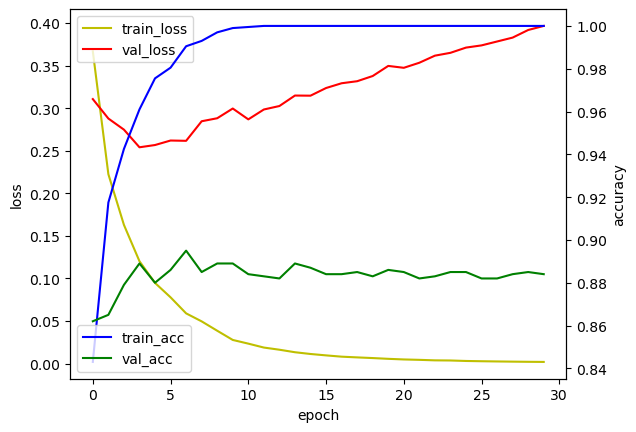

In [28]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history["loss"], "y", label="train_loss")
loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
loss_ax.set_xlabel("epoch")
loss_ax.set_ylabel("loss")
loss_ax.legend(loc="upper left")

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
acc_ax.set_ylabel("accuracy")
acc_ax.legend(loc="lower left")